In [23]:
#steps: import libs, dataset, EDA, preprocessing, train test split, evaluate, visualise

In [24]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import resample


In [25]:
#load the dataset
df = pd.read_csv('archive.zip')
df.head()

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
0,s1,Movie,Dick Johnson Is Dead,Kirsten Johnson,NaN,United States,"September 25, 2021",2020,PG-13,90 min,Documentaries,"As her father nears the end of his life, filmm..."
1,s2,TV Show,Blood & Water,NaN,"Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...",South Africa,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, TV Dramas, TV Mysteries","After crossing paths at a party, a Cape Town t..."
2,s3,TV Show,Ganglands,Julien Leclercq,"Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabi...",NaN,"September 24, 2021",2021,TV-MA,1 Season,"Crime TV Shows, International TV Shows, TV Act...",To protect his family from a powerful drug lor...
3,s4,TV Show,Jailbirds New Orleans,NaN,NaN,NaN,"September 24, 2021",2021,TV-MA,1 Season,"Docuseries, Reality TV","Feuds, flirtations and toilet talk go down amo..."
4,s5,TV Show,Kota Factory,NaN,"Mayur More, Jitendra Kumar, Ranjan Raj, Alam K...",India,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, Romantic TV Shows, TV ...",In a city of coaching centers known to train I...


In [26]:
#Exploratory Data Analysis
df.info()
df.describe()
df.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8807 entries, 0 to 8806
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   show_id       8807 non-null   object
 1   type          8807 non-null   object
 2   title         8807 non-null   object
 3   director      6173 non-null   object
 4   cast          7982 non-null   object
 5   country       7976 non-null   object
 6   date_added    8797 non-null   object
 7   release_year  8807 non-null   int64 
 8   rating        8803 non-null   object
 9   duration      8804 non-null   object
 10  listed_in     8807 non-null   object
 11  description   8807 non-null   object
dtypes: int64(1), object(11)
memory usage: 825.8+ KB


show_id            0
type               0
title              0
director        2634
cast             825
country          831
date_added        10
release_year       0
rating             4
duration           3
listed_in          0
description        0
dtype: int64

In [27]:
df = df[['release_year', 'rating', 'director', 'cast', 'type', 'country', 'date_added', 'duration', 'listed_in']]
df.dropna(inplace=True)

df[['duration_num', 'duration_type']] = df['duration'].str.split(' ', expand=True)
df['type'] = df['type'].map({ 'Movie': 1, 'TV Show': 0})
df['date_added'] = pd.to_datetime(df['date_added'], errors='coerce')
df['is_recent'] = df['date_added'].apply(lambda x: 1 if pd.notnull(x) and x.year >= 2020 else 0)
popular_directors = df['director'].value_counts().head().index.tolist()
df['famous_director'] = df['director'].apply(lambda x: 1 if x in popular_directors else 0)
df['is_popular'] = df.apply(lambda row: 1 if(
    row['is_recent'] == 1 or
    row['rating'] in ['R', 'PG-13', 'TV-MA'] or
    row['famous_director'] == 1
) else 0, axis=1)
df['cast_count'] = df['cast'].apply(lambda x: len(str(x).split(',')) if pd.notnull(x) else 0)

In [28]:
#resampling
df_majority = df[df['is_popular'] == 0]
df_minority = df[df['is_popular'] == 1]

df_minority_upsampled = resample(
    df_minority,
    replace = True,
    n_samples = len(df_majority),
    random_state=42
)

#combine them into a balanced dataset:
df_balanced = pd.concat([df_majority, df_minority_upsampled])
df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)
print(df_balanced['is_popular'].value_counts())


is_popular
1    1480
0    1480
Name: count, dtype: int64


In [29]:
#One hot encoder
df_balanced['country'] = LabelEncoder().fit_transform(df_balanced['country'])
df_balanced['duration_type'] = LabelEncoder().fit_transform(df_balanced['duration_type'])
df_balanced['genre'] = df_balanced['listed_in'].apply(lambda x: x.split(',')[0])
df_balanced['genre'] = LabelEncoder().fit_transform(df_balanced['genre'])
df_balanced['rating'] = LabelEncoder().fit_transform(df_balanced['rating'])


In [30]:
df_balanced = df_balanced[['type', 'country', 'release_year', 'cast_count', 'duration_num', 'duration_type', 'genre', 'famous_director', 'is_popular', 'rating']]
df_balanced

,type,country,release_year,cast_count,duration_num,duration_type,genre,famous_director,is_popular,rating
0,1,274,1990,12,96,2,7,0,1,4
1,1,179,2019,7,94,2,12,0,1,8
2,1,109,2005,11,149,2,12,0,0,9
3,1,147,2016,6,72,2,0,0,1,6
4,1,274,2016,8,90,2,7,0,1,5
...,...,...,...,...,...,...,...,...,...,...
2955,1,274,2021,9,107,2,0,0,1,4
2956,1,274,2017,1,55,2,10,0,0,9
2957,1,173,2015,9,135,2,12,0,0,6
2958,1,109,2008,10,135,2,12,0,0,6


In [31]:
X = df_balanced[['country', 'release_year', 'cast_count', 'duration_num', 'duration_type', 'genre', 'famous_director', 'rating']]
y = df_balanced['is_popular']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = RandomForestClassifier(max_depth=10, random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
print(accuracy_score(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.89      1.00      0.94       289
           1       1.00      0.88      0.94       303

    accuracy                           0.94       592
   macro avg       0.94      0.94      0.94       592
weighted avg       0.95      0.94      0.94       592

[[288   1]
 [ 35 268]]
0.9391891891891891


In [32]:
print(df_balanced['is_popular'].value_counts())

is_popular
1    1480
0    1480
Name: count, dtype: int64


<Figure size 800x600 with 0 Axes>

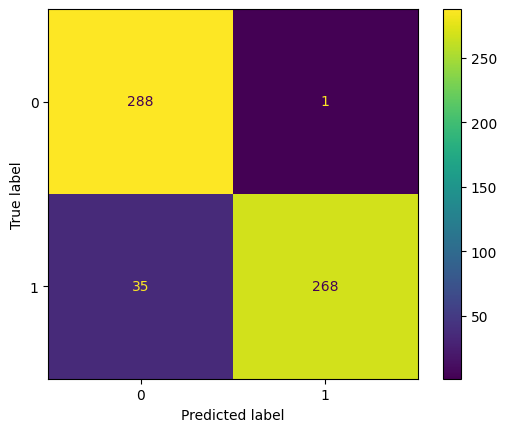

In [33]:
plt.figure(figsize=(8, 6))
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(model, X_test, y_test)


<Figure size 800x600 with 0 Axes>

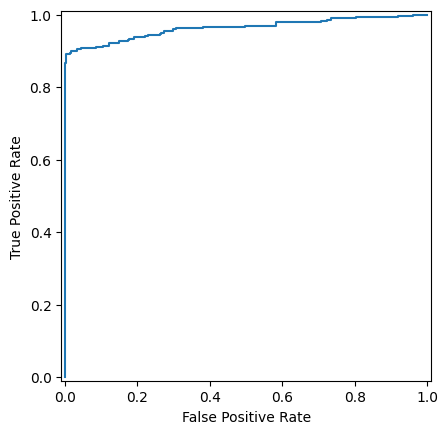

In [34]:
plt.figure(figsize=(8, 6))
from sklearn.metrics import roc_curve, RocCurveDisplay

y_prob = model.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_prob)
RocCurveDisplay(fpr=fpr, tpr=tpr).plot()


<Figure size 800x600 with 0 Axes>

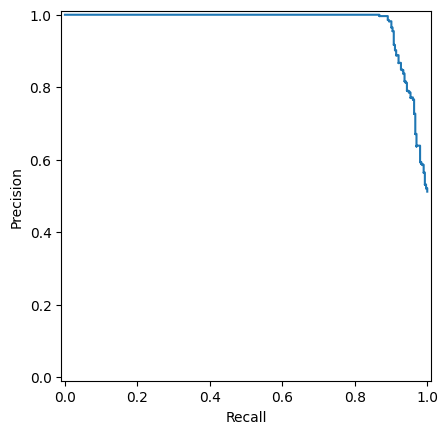

In [35]:
plt.figure(figsize=(8, 6))
from sklearn.metrics import precision_recall_curve, PrecisionRecallDisplay

precision, recall, _ = precision_recall_curve(y_test, y_prob)
PrecisionRecallDisplay(precision=precision, recall=recall).plot()


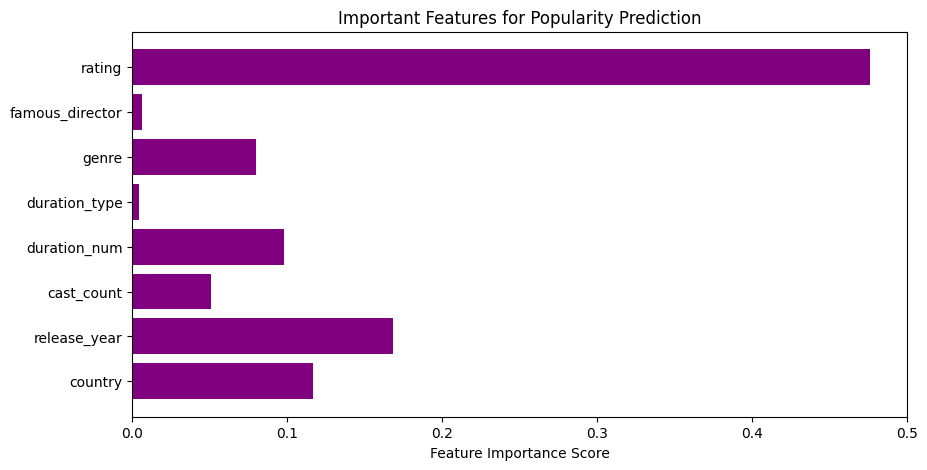

In [36]:
features = X.columns
importances = model.feature_importances_

plt.figure(figsize=(10,5))
plt.barh(features, importances, color='purple')
plt.xlabel("Feature Importance Score")
plt.title("Important Features for Popularity Prediction")
plt.show()